<a href="https://colab.research.google.com/github/ajay-nrg/DeepLearning/blob/master/4_Predicting_house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from keras.datasets import boston_housing

(train_data,train_targets),(test_data,test_targets) = boston_housing.load_data()

In [19]:
print(train_data.shape)
test_data.shape

(404, 13)


(102, 13)

In [20]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
train_data

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

In [21]:
test_data -= mean
test_data /= std
test_data

array([[ 1.55369355, -0.48361547,  1.0283258 , ...,  0.78447637,
        -3.48459553,  2.25092074],
       [-0.39242675, -0.48361547, -0.16087773, ..., -0.30759583,
         0.42733126,  0.47880119],
       [-0.39982927, -0.48361547, -0.86940196, ...,  0.78447637,
         0.44807713, -0.41415936],
       ...,
       [-0.20709507, -0.48361547,  1.24588095, ..., -1.71818909,
         0.37051949, -1.49344089],
       [-0.36698601, -0.48361547, -0.72093526, ..., -0.48960787,
         0.39275481, -0.41829982],
       [-0.0889679 , -0.48361547,  1.24588095, ..., -1.71818909,
        -1.21946544, -0.40449827]])

In [25]:
#Model definition

from keras import models 
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64,activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

#The network ends with a single unit and no activation (it will be a linear layer). This is
#a typical setup for scalar regression (a regression where you’re trying to predict a single
#continuous value).

In [28]:
#K-fold validation

import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

#Prepares the validation data: data from partition #k
for i in range(k):
  print('processing fold #',i)
  val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  #Prepares the training data: data from all other partitions
  partial_train_data = np.concatenate([train_data[:i* num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
  partial_train_targets = np.concatenate([train_targets[:i* num_val_samples],train_targets[(i+1)*num_val_samples:]], axis=0)

  model = build_model() #Builds the Keras model (already compiled)

  model.fit(partial_train_data,partial_train_targets,epochs=num_epochs,batch_size=1,verbose=0)
  #Trains the model (in silent mode,verbose = 0)
  
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [34]:
print(all_scores)
np.mean(all_scores)

[2.101224422454834, 2.973715305328369, 2.4139130115509033, 2.522993326187134]


2.50296151638031

In [46]:
#Saving the validation logs at each fold
num_epochs = 100
all_mae_histories = []

for i in range(k):
  print('processing fold #',i)
  val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  #Prepares the training data: data from all other partitions
  partial_train_data = np.concatenate([train_data[:i* num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
  partial_train_targets = np.concatenate([train_targets[:i* num_val_samples],train_targets[(i+1)*num_val_samples:]], axis=0)

  model = build_model() #Builds the Keras model (already compiled)

  history = model.fit(partial_train_data,partial_train_targets,
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs,batch_size=1,verbose=0)
  #Trains the model (in silent mode,verbose = 0)
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [53]:
#Building the history of successive mean K-fold validation scores
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_history[:5]

[4.53826105594635,
 3.3585904836654663,
 2.971972644329071,
 2.901795506477356,
 2.892486572265625]

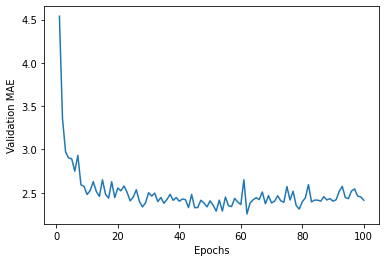

In [54]:
#Plotting validation scores
import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [56]:
#training the model
model = build_model()
model.fit(train_data, train_targets,
epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 172us/step


In [57]:
test_mae_score

2.666041374206543